# Differentiable Spearman Rank Correlation

*Version History*

* **6.0** - Run Monte Carlo experiments and visualize results
* **6.1** - Modify figures, visualize relation between Pearson (population/sample) and Spearman correlation
* **6.2** - Clean up code, vastly improve code to produce figures 
* **6.3** - Modify figures, perform benchmarking of ``soft_rank``


## Imports

In [1]:
import pickle
import re
from functools import partial
from itertools import product
from pathlib import Path
from typing import Literal, Optional, Sequence, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.utils.benchmark as benchmark
from fast_soft_sort.pytorch_ops import soft_rank
from matplotlib.font_manager import FontProperties
from pyfonts import load_font
from scipy import stats
from torch.nn import functional as F
from tqdm import tqdm

from src.utils.training import set_device
from src.visualization.color import get_color
from src.visualization.saving import save_figure


# Custom font & colors for plotting purposes
indie_flower = load_font(
   font_url="https://github.com/google/fonts/blob/main/ofl/indieflower/IndieFlower-Regular.ttf?raw=true"
)
anthracite = get_color("anthracite", tint=0.2)
anthracite_light = get_color("anthracite", tint=0.75)
colors = [
    get_color("thatch"),
    get_color("dark-wood"),
    get_color("tangerine"),
    get_color("grenadier")
]
full_palette = sns.color_palette(colors)
partial_palette = sns.color_palette(colors[1:])

## Current Implementation of Spearman Rank Correlation


### Helper Functions

In [2]:
def _is_vector(x: torch.Tensor) -> bool:
    """Check if the input is a ``torch.Tensor`` of dimension 1."""

    return isinstance(x, torch.Tensor) and x.dim() == 1


def _rank_data(data: torch.Tensor) -> torch.Tensor:
    """Assign ranks to data, with ties resolved by averaging.

    Args:
        data: The data tensor for which to assign ranks.

    Returns:
        The ranks of the data tensor, with ties resolved by averaging.
        Ranks are 1-based and have the same dtype and device as the
        input tensor.
    """

    if not _is_vector(data):
        raise ValueError("'data' should be a 1-D tensor.")

    # Determine ordinal ranks
    n = data.numel()
    rank = torch.empty_like(data)
    idx = data.argsort()
    rank[idx[:n]] = torch.arange(1, n + 1, dtype=data.dtype, device=data.device)

    # Identify duplicate entries in ``data`` tensor
    unique_values, counts = torch.unique(data, return_counts=True)
    duplicate_values = unique_values[counts > 1]

    # Convert ordinal ranks to average ranks for duplicate entries
    for value in duplicate_values:
        mask = data == value
        rank[mask] = rank[mask].float().mean()

    return rank


def _compare_rdm_correlation(
        rdm1: torch.Tensor,
        rdm2: torch.Tensor
) -> torch.Tensor:
    """Compare two RDMs using Pearson correlation.

    Args:
        rdm1: The first RDM in vectorized form.
        rdm2: The second RDM in vectorized form.

    Returns:
        The Pearson correlation between the two RDMs.
    """

    # NOTE: The Pearson correlation of two vectors is the same as the cosine similarity between the
    #       centered vectors.
    rdm1 = rdm1 - rdm1.mean()
    rdm2 = rdm2 - rdm2.mean()
    return F.cosine_similarity(rdm1, rdm2, dim=0)


### Spearman Rank Correlation

In [3]:
def _compare_rdm_spearman(
        rdm1: torch.Tensor,
        rdm2: torch.Tensor
) -> torch.Tensor:
    """Compare two RDMs using Spearman rank correlation.

    Note:
        When computing ranks of the dissimilarities for each RDM, ties
        are assigned the average of the ranks that would have been
        assigned to each value.  This mimics the default behavior of the
        ``scipy.stats.rankdata`` function.

    Args:
        rdm1: The first RDM in vectorized form.
        rdm2: The second RDM in vectorized form.

    Returns:
        The Spearman rank correlation between the two RDMs.
    """

    # Compute Pearson correlation between the rank variables
    rdm1_ranks, rdm2_ranks = _rank_data(rdm1), _rank_data(rdm2)
    return _compare_rdm_correlation(rdm1_ranks, rdm2_ranks)


## Non-Differentiability in PyTorch


### Issue

PyTorch does *not* throw an error when computing gradients of a loss function including Spearman's rank correlation coefficient even  
though the ranking function that's part of Spearman's rank correlation is either constant or has a discontinuity. Hence, the partial  
derivatives are either $0$ or they do not exist, so that it should be impossible to optimize w.r.t. Spearman's rank correlation.

The reason why PyTorch is *seemingly* still optimizing the loss function is illustrated by the following toy example:

In [4]:
dummy_cross_entropy = torch.tensor([0.2483], requires_grad=True)
rdm1 = torch.rand(size=[10], requires_grad=True)
rdm2 = torch.rand(size=[10], requires_grad=True)
similarity = _compare_rdm_spearman(rdm1, rdm2)

loss = 0.8 * similarity + 0.2 * dummy_cross_entropy
loss.backward()

print(f"\033[1mrdm1\033[0m: {rdm1.grad}")
print(f"\033[1mrdm2\033[0m: {rdm2.grad}")
print(f"\033[1mdummy_cross_entropy\033[0m: {dummy_cross_entropy.grad}")

rdm1: None
rdm2: None
dummy_cross_entropy: tensor([0.2000])


### Explanation

PyTorch simply doesn't raise an error when it cannot compute a gradient of a function w.r.t. some variables *as long as the function  
is differentiable with respect to at least one variable*.


### Solution

Implement a version of Spearman's rank correlation that uses a smooth ranking operation introduced in the following article:

> Blondel, M., Teboul, O., Berthet, Q., & Djolonga, J. (2020). Fast differentiable sorting and ranking. *Proceedings of the 37th International Conference on Machine Learning, 119*, 950–959.


## Differentiable Spearman Rank Correlation


### Helper Function

In [5]:
def pearson_corr_by_row(
    vec1: torch.Tensor,
    vec2: torch.Tensor
) -> torch.Tensor:
    """Compute the Pearson corr. between corresponding rows of matrices.

    Args:
        vec1: The first set of vectors.  Must be a 2-D tensor.
        vec2: The second set of vectors.  Must be a 2-D tensor of the
          same shape as ``vec1``.

    Returns:
        A tensor containing the Pearson correlation coefficients between
        corresponding rows of the two matrices ``vec1`` and ``vec2``.
    """
    
    if not (vec1.dim() == 2 and vec2.dim() == 2 and vec1.shape == vec2.shape):
        raise ValueError(
            "'vec1' and 'vec2' must be 2-D tensors of the same shape."
        )

    vec1 = vec1 - vec1.mean(dim=1, keepdim=True)
    vec2 = vec2 - vec2.mean(dim=1, keepdim=True)

    cov = (vec1 * vec2).sum(dim=1)
    vec1_std = vec1.pow(2).sum(dim=1).sqrt()
    vec2_std = vec2.pow(2).sum(dim=1).sqrt()

    return cov / (vec1_std * vec2_std)


### Implementation

Unfortunately, the *fast_soft_sort* package only seems to support tensors on the CPU:

In [6]:
dummy_tensor = torch.randn(10, device="mps")
print(dummy_tensor.device)
# soft_rank(dummy_tensor.unsqueeze(dim=0))  # Uncommenting this line will raise a TypeError!

mps:0


Hence, it is necessary to move tensors to the CPU before computing ranks via the ``soft_rank`` function.

In [7]:
def differentiable_spearman(
        vec1: torch.Tensor,
        vec2: torch.Tensor,
        regularization_strength: float = 1.0,
        regularization: Literal["l2", "kl"] = "l2"
) -> torch.Tensor:
    """Compute Spearman rank correlations between two sets of vectors.

    Args:
        vec1: The first set of vectors.  Must be a 2-D tensor.
        vec2: The second set of vectors.  Must be a 2-D tensor of the
          same shape as ``vec1``.
        regularization_strength: The regularization strength to be used.
          The smaller this number, the closer the values are to the rank
          correlations using true ranks.
        regularization: The regularization method to be used when
          computing soft ranks.

    Returns:
        The Spearman rank correlations between the two sets of vectors,
        computed using soft ranks.
    """

    # Store device that tensors are initially on
    device = vec1.device

    vec1_ranks = soft_rank(
        vec1.cpu(),
        regularization_strength=regularization_strength,
        regularization=regularization
    ).to(device)
    
    vec2_ranks = soft_rank(
        vec2.cpu(),
        regularization_strength=regularization_strength,
        regularization=regularization
    ).to(device)

    return pearson_corr_by_row(vec1_ranks, vec2_ranks)


## Monte Carlo Experiment

The ``soft_rank`` function takes two arguments that influence the smoothness of the ranking function as well as the values  
it outputs (i.e. how close the values are to the true ranks). Ideally, we want the values to be nearly identical to the true ranks,  
while having as many non-zero partial derivatives as possible (to aid optimization via backpropagation). Smaller values of the  
``regularization_strength`` parameter yield outputs that are closer to the true ranks, at the expense of the function's  
smoothness. To evaluate this tradeoff, we run simulations using the Monte Carlo method.


### Helper Functions

We need to sample from two random variables with a given correlation. For this, we recall some basic probability theory.  
Let $\mathbf{Z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}_k)$ be a standard normal random vector (i.e., the $Z_i$ are *independent* standard normal random variables).  
Let $\mathbf{\Sigma}$ be a real-valued symmetric positive-definite matrix and let $\mathbf{\Sigma} = \mathbf{L} \mathbf{L}^{\top}$ be its Cholesky decomposition, where $\mathbf{L}$ is a  
lower triangular matrix with positive entries on the diagonal. Then, the linear transformation $\mathbf{X} = \mathbf{L}\mathbf{Z}$ also follows a  
multivariate normal distribution with mean
$$
\mathbb{E}(\mathbf{X}) = \mathbb{E}(\mathbf{L}\mathbf{Z}) = \mathbf{L}\mathbb{E}(\mathbf{Z}) = \mathbf{0}
$$
and variance-covariance matrix
$$
\mathrm{Cov}(\mathbf{X}) = \mathrm{Cov}(\mathbf{L}\mathbf{Z}) = \mathbf{L}\mathrm{Cov}(\mathbf{Z})\mathbf{L}^{\top} = \mathbf{L}\mathbf{L}^{\top} = \mathbf{\Sigma} \,.
$$
In the two-dimensional case, we can let
$$
\mathbf{\Sigma} = \begin{bmatrix}
    1 & \rho \\
    \rho & 1
\end{bmatrix} \,.
$$
The lower triangular matrix $\mathbf{L}$ of the Cholesky decomposition of $\mathbf{\Sigma}$ is given by
$$
\begin{bmatrix}
    1 & 0 \\
    \rho & \sqrt{1 - \rho^2}
\end{bmatrix}
$$
so that
$$
X_1 = Z_1, \quad X_2 = \rho Z_1 + \sqrt{1 - \rho^2} Z_2
$$
are two standard normal random variables with covariance $\rho$. As both random variables have unit variance, their correlation  
equals $\rho$ as well.

In [8]:
def randn_corr(
    size: Sequence[int],
    corr: float,
    generator: Optional[torch.Generator] = None,
    device: Optional[torch.device] = None
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Sample from bivariate normal distrib. w/ stand. norm. marginals.

    Note:
        The parameter ``corr`` controls the population correlation, not
        the sample correlation.  The pairwise sample correlations
        between the two sets of vectors that are returned by this
        function naturally differ from the specified population
        correlation ``corr``.
    
    Args:
        size: A sequence of integers defining the shape of each of the
          two output tensors.
        corr: The desired correlation between the two random variables
          from which to draw samples repeatedly.
        generator: A pseudorandom number generator for sampling
          purposes.
        device: The desired device of the returned tensors.
    """

    # Draw samples from independent standard normal variables
    z1 = torch.randn(size, generator=generator, device=device)
    z2 = torch.randn(size, generator=generator, device=device)

    # Transform to achieve desired correlation
    x1, x2 = z1, corr * z1 + torch.sqrt(torch.tensor([1 - corr**2], device=device)) * z2
    return x1, x2


### Function to Run Monte Carlo Experiment

In [9]:
def monte_carlo_soft_rank(
    num_repetitions: int,
    size: int,
    corr: float,
    regularization: Literal["l2", "kl"],
    regularization_strength: float,
    generator: torch.Generator,
    device: Optional[torch.device] = None
) -> pd.DataFrame:
    """Evaluate the ``soft_rank`` function using the Monte Carlo method.

    Note:
        When ``num_repetitions`` and ``size`` are both small, it is
        faster to perform computations on the CPU, as the overhead
        incurred by having to transfer data between CPU and GPU will
        outweigh the benefit of parallel computation on the GPU.
    
    Args:
        num_repetitions: The number of times to repeat the experiment.
        size: The number of samples to draw from each of the two
          correlated standard normal variables per repetition.
        corr: The desired correlation between the two random variables
          from which to draw samples repeatedly.
        regularization: The regularization method to be used by the
          ``soft_rank`` function.
        regularization_strength: The regularization strength to be used
          by the ``soft_rank`` function.
        generator: A pseudorandom number generator for sampling
          purposes.
        device: The device on which to perform computations.

    Returns:
        A DataFrame storing the results of the experiment.
    """

    # Sample from correlated standard normal variables & compute Pearson's correlation coefficient
    vec1, vec2 = randn_corr(
        size=(num_repetitions, size),
        corr=corr,
        generator=generator,
        device=device
    )
    pearson_corr = pearson_corr_by_row(vec1, vec2)

    # Compute Spearman rank correlation using true ranks
    tensor_type = "float32" if str(device) == "mps" else "float64"  # mps doesn't support float64
    true_rank_corr = pearson_corr_by_row(
        torch.tensor(stats.rankdata(vec1.cpu(), axis=1).astype(tensor_type), device=device),
        torch.tensor(stats.rankdata(vec2.cpu(), axis=1).astype(tensor_type), device=device)
    )

    # Compute Spearman rank correlation using soft ranks
    vec1.requires_grad_(True), vec2.requires_grad_(True)
    soft_rank_corr = differentiable_spearman(
        vec1, vec2,
        regularization_strength=regularization_strength,
        regularization=regularization
    )

    # Compute gradient and count non-zero partial derivatives
    soft_rank_corr.sum().backward()
    non_zero_partials_vec1 = (vec1.grad != 0).sum(dim=1)
    non_zero_partials_vec2 = (vec2.grad != 0).sum(dim=1)
    non_zero_partials = non_zero_partials_vec1 + non_zero_partials_vec2

    # Arrange in DataFrame
    results = pd.DataFrame({
        "size": size,
        "corr_sampled": corr,
        "pearson_corr": pearson_corr.cpu(),
        "regularization": regularization,
        "regularization_strength": regularization_strength,
        "true_rank_corr": true_rank_corr.cpu(),
        "soft_rank_corr": soft_rank_corr.detach().cpu(),
        "non_zero_partials": non_zero_partials.cpu(),
        "total_partials": 2 * size
    })
    
    return results


### Running the Experiment

### Data Preprocessing

In [10]:
# Load data
df = pd.read_csv("../reports/data/diff_spearman/monte-carlo.csv")

# Compute absolute differences & relative availability of non-zero gradients
df["abs_diff"] = (df["soft_rank_corr"] - df["true_rank_corr"]).abs()
df["non_zero_partials"] = df["non_zero_partials"] / df["total_partials"]

# Rearrange DataFrame
df = df.drop(columns=["pearson_corr", "true_rank_corr", "soft_rank_corr", "total_partials"])
df = df.melt(
    id_vars=["repetition", "size", "corr_sampled", "regularization_strength", "regularization"],
    value_vars=["abs_diff", "non_zero_partials"]
)

# Inspect structure
df.head()

,repetition,size,corr_sampled,regularization_strength,regularization,variable,value
0,0,28,0.2,0.0001,l2,abs_diff,0.0
1,1,28,0.2,0.0001,l2,abs_diff,0.0
2,2,28,0.2,0.0001,l2,abs_diff,0.0
3,3,28,0.2,0.0001,l2,abs_diff,0.0
4,4,28,0.2,0.0001,l2,abs_diff,0.0


### Figures


#### L2: Error

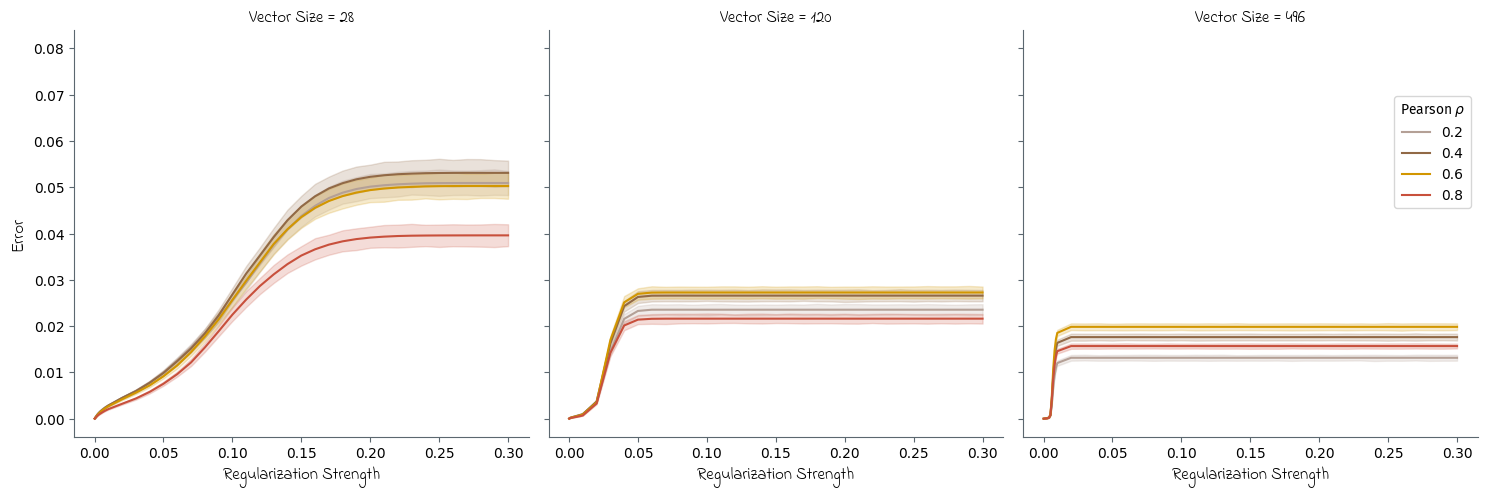

In [11]:
# Plot data
with sns.axes_style({"axes.edgecolor": anthracite}):
    g = sns.relplot(
        data=df.query("regularization == 'l2' and variable == 'abs_diff'"),
        x="regularization_strength",
        y="value",
        hue="corr_sampled",
        col="size",
        palette=full_palette,
        kind="line"
    )

# Add axis labels and modify margin titles
g.set_axis_labels("Regularization Strength", "Error", font=indie_flower, size=12)
g.set_titles(
    col_template="Vector Size = {col_name}",
    font=indie_flower,
    size=12
)

# Customize legend
h, l = g.axes[0][0].get_legend_handles_labels()
g._legend.remove()
g.axes[0][2].legend(
    h, l,
    loc="center right",
    bbox_to_anchor=(1, 0.7),
    title=r"Pearson $\rho$",
    title_fontproperties=FontProperties(family="Fira Sans")
)

# Control figure aesthetics
g.set(ylim=(-0.004, 0.084))
g.tick_params(color=anthracite)

fig_l2_error = g.figure
plt.show()

#### L2: Non-Zero Partial Derivatives

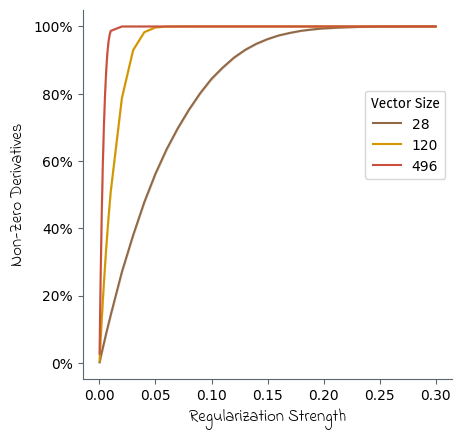

In [12]:
# Plot data
with sns.axes_style({"axes.edgecolor": anthracite}):
    ax = sns.lineplot(
        data=df.query("regularization == 'l2' and variable == 'non_zero_partials'"),
        x="regularization_strength",
        y="value",
        hue="size",
        palette=partial_palette
    )

# Add axis labels
ax.set_xlabel("Regularization Strength", font=indie_flower, size=12)
ax.set_ylabel("Non-Zero Derivatives", font=indie_flower, size=12)

# Modify tick labels
ax.set_yticks([0.1 * x for x in range(0, 12, 2)])
ax.set_yticklabels([f"{x}%" for x in range(0, 120, 20)])

# Customize legend
h, l = ax.get_legend_handles_labels()
ax.legend(
    h, l,
    loc="upper right",
    bbox_to_anchor=(1, 0.8),
    title="Vector Size",
    title_fontproperties=FontProperties(family="Fira Sans")
)

# Control figure aesthetics
ax.set_box_aspect(1)
sns.despine(ax=ax)
ax.tick_params(color=anthracite)

fig_l2_derivatives = ax.get_figure()
plt.show()

#### Kullback-Leibler: Error

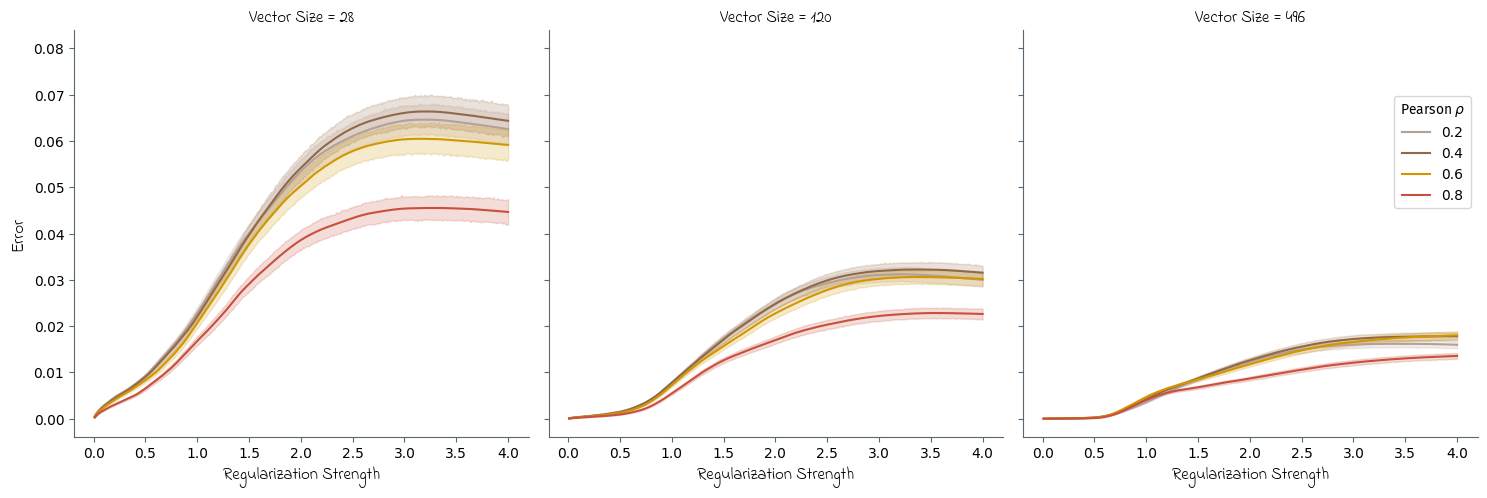

In [13]:
# Plot data
with sns.axes_style({"axes.edgecolor": anthracite}):
    g = sns.relplot(
        data=df.query("regularization == 'kl' and variable == 'abs_diff'"),
        x="regularization_strength",
        y="value",
        hue="corr_sampled",
        col="size",
        palette=full_palette,
        kind="line"
    )

# Add axis labels and modify margin titles
g.set_axis_labels("Regularization Strength", "Error", font=indie_flower, size=12)
g.set_titles(
    col_template="Vector Size = {col_name}",
    font=indie_flower,
    size=12
)

# Customize legend
h, l = g.axes[0][0].get_legend_handles_labels()
g._legend.remove()
g.axes[0][2].legend(
    h, l,
    loc="center right",
    bbox_to_anchor=(1, 0.7),
    title=r"Pearson $\rho$",
    title_fontproperties=FontProperties(family="Fira Sans")
)

# Control figure aesthetics
g.set(ylim=(-0.004, 0.084))
g.tick_params(color=anthracite)

fig_kl_error = g.figure
plt.show()

#### Kullback-Leibler: Non-Zero Partial Derivatives

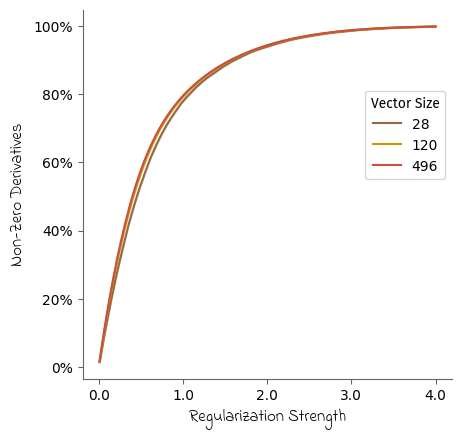

In [14]:
# Plot data
with sns.axes_style({"axes.edgecolor": anthracite}):
    ax = sns.lineplot(
        data=df.query("regularization == 'kl' and variable == 'non_zero_partials'"),
        x="regularization_strength",
        y="value",
        hue="size",
        palette=partial_palette
    )

# Add axis labels
ax.set_xlabel("Regularization Strength", font=indie_flower, size=12)
ax.set_ylabel("Non-Zero Derivatives", font=indie_flower, size=12)

# Modify tick labels
ax.set_xticks(range(0, 5))
ax.set_xticklabels([f"{x:.1f}" for x in range(0, 5)])
ax.set_yticks([0.1 * x for x in range(0, 12, 2)])
ax.set_yticklabels([f"{x}%" for x in range(0, 120, 20)])

# Customize legend
h, l = ax.get_legend_handles_labels()
ax.legend(
    h, l,
    loc="upper right",
    bbox_to_anchor=(1, 0.8),
    title="Vector Size",
    title_fontproperties=FontProperties(family="Fira Sans")
)

# Control figure aesthetics
ax.set_box_aspect(1)
sns.despine(ax=ax)
ax.tick_params(color=anthracite)

fig_kl_derivatives = ax.get_figure()
plt.show()

### Further Analysis: Error as a Function of Non-Zero Partial Derivatives

Ultimately, we want to know how much we have to pay, in terms of deviation from Spearman's rank correlation using true ranks, for a  
given level of non-zero partial derivatives. That is, we want maps ``non_zero_partials`` $\to$ ``abs_diff`` for both regularization  
methods and all combinations of the ``size`` and ``corr_sampled`` parameters. We now construct exactly these maps. First, we  
compute the average ``non_zero_partials`` for each ``regularization`` method and each ``size`` (we average across different  
``corr_sampled`` values since the ``non_zero_partials`` values do not depend on the ``corr_sampled`` parameter).

In [15]:
# Compute avg. ``non_zero_partials`` across repetitions and (true) correlations
partials_avg = df[df["variable"] == "non_zero_partials"].drop(columns="variable")
partials_avg = partials_avg.groupby(
    ["size", "regularization_strength", "regularization"],
    as_index=False
)["value"].mean()

# Reorder and rename columns, sort rows
partials_avg = partials_avg[["regularization", "size", "regularization_strength", "value"]]
partials_avg.rename(columns={"value": "avg_non_zero_partials"}, inplace=True)
partials_avg

,regularization,size,regularization_strength,avg_non_zero_partials
0,l2,28,0.0001,0.001214
1,l2,28,0.0002,0.002629
2,l2,28,0.0003,0.004138
3,l2,28,0.0004,0.005911
4,l2,28,0.0005,0.007326
...,...,...,...,...
1339,kl,496,3.9600,0.997899
1340,kl,496,3.9700,0.997941
1341,kl,496,3.9800,0.997984
1342,kl,496,3.9900,0.998018


Next, we create a DataFrame storing the inverse mapping ``avg_non_zero_partials`` $\to$ ``regularization_strength``.

In [16]:
# Set up DataFrame
regularization_vals = ["l2", "kl"]
size_vals = [28, 120, 496]
avg_non_zero_partials_vals = np.arange(0.005, 1, 0.005)
inverse_partials = pd.DataFrame(
    [(reg, size, avg) for reg in regularization_vals for size in size_vals for avg in avg_non_zero_partials_vals],
    columns=["regularization", "size", "non_zero_partials"]
)

# Left join ``partials_avg``
inverse_partials = pd.merge(inverse_partials, partials_avg, on=["regularization", "size"])

# Determine smallest ``regularization_strength`` leading to given ``non_zero_partials`` value
inverse_partials = inverse_partials[inverse_partials["avg_non_zero_partials"] >= inverse_partials["non_zero_partials"]]
inverse_partials = inverse_partials.loc[inverse_partials.groupby(
    ["regularization", "size", "non_zero_partials"]
)["regularization_strength"].idxmin()]
inverse_partials = inverse_partials.drop(columns=["avg_non_zero_partials"])
inverse_partials = inverse_partials.sort_values(
    by=["regularization", "size", "non_zero_partials"]
).reset_index(drop=True)
inverse_partials

,regularization,size,non_zero_partials,regularization_strength
0,kl,28,0.005,0.01
1,kl,28,0.010,0.01
2,kl,28,0.015,0.02
3,kl,28,0.020,0.02
4,kl,28,0.025,0.02
...,...,...,...,...
1189,l2,496,0.975,0.01
1190,l2,496,0.980,0.01
1191,l2,496,0.985,0.01
1192,l2,496,0.990,0.02


To continue, we compute the average ``abs_diff`` for each ``regularization`` method, each ``size``, and each ``corr_sampled``.

In [17]:
# Compute avg. ``abs_diff`` across repetitions
diff_avg = df[df["variable"] == "abs_diff"].drop(columns="variable")
diff_avg = diff_avg.groupby(
    ["size", "corr_sampled", "regularization_strength", "regularization"],
    as_index=False
)["value"].mean()

# Reorder and rename columns, sort rows
diff_avg = diff_avg[["regularization", "size", "corr_sampled", "regularization_strength", "value"]]
diff_avg.rename(columns={"value": "avg_abs_diff"}, inplace=True)
diff_avg

,regularization,size,corr_sampled,regularization_strength,avg_abs_diff
0,l2,28,0.2,0.0001,0.000042
1,l2,28,0.2,0.0002,0.000092
2,l2,28,0.2,0.0003,0.000142
3,l2,28,0.2,0.0004,0.000203
4,l2,28,0.2,0.0005,0.000263
...,...,...,...,...,...
5371,kl,496,0.8,3.9600,0.013530
5372,kl,496,0.8,3.9700,0.013539
5373,kl,496,0.8,3.9800,0.013547
5374,kl,496,0.8,3.9900,0.013556


All that's left to do now, is to join the two DataFrames ``inverse_partials`` and ``diff_avg`` to arrive at the desired maps  
``non_zero_partials`` $\to$ ``abs_diff`` for both regularization methods and all combinations of ``size`` and ``corr_sampled``.

In [18]:
partials_to_diff = pd.merge(inverse_partials, diff_avg, on=["regularization", "size", "regularization_strength"])
partials_to_diff

,regularization,size,non_zero_partials,regularization_strength,corr_sampled,avg_abs_diff
0,kl,28,0.005,0.01,0.2,0.000489
1,kl,28,0.005,0.01,0.4,0.000433
2,kl,28,0.005,0.01,0.6,0.000373
3,kl,28,0.005,0.01,0.8,0.000281
4,kl,28,0.010,0.01,0.2,0.000489
...,...,...,...,...,...,...
4771,l2,496,0.990,0.02,0.8,0.015694
4772,l2,496,0.995,0.02,0.2,0.013165
4773,l2,496,0.995,0.02,0.4,0.017631
4774,l2,496,0.995,0.02,0.6,0.019849


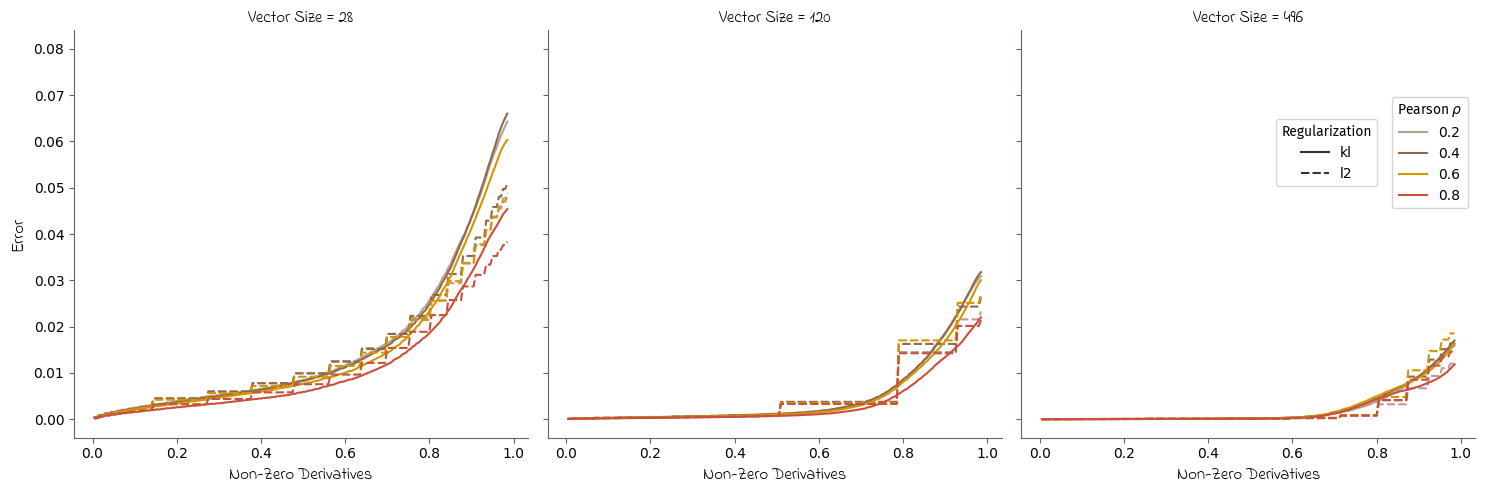

In [19]:
# Plot data
with sns.axes_style({"axes.edgecolor": anthracite}):
    g = sns.relplot(
        data=partials_to_diff[partials_to_diff["non_zero_partials"] < 0.99],
        x="non_zero_partials",
        y="avg_abs_diff",
        hue="corr_sampled",
        style="regularization",
        col="size",
        palette=full_palette,
        kind="line"
    )

# Add axis labels and modify margin titles
g.set_axis_labels("Non-Zero Derivatives", "Error", font=indie_flower, size=12)
g.set_titles(
    col_template="Vector Size = {col_name}",
    font=indie_flower,
    size=12
)

# Customize legend
handles, labels = g.axes[0][0].get_legend_handles_labels()
g._legend.remove()
rglr_legend = g.axes[0][2].legend(
    handles[-2:],
    labels[-2:],
    loc="center right",
    bbox_to_anchor=(0.8, 0.7),
    title="Regularization",
    title_fontproperties=FontProperties(family="Fira Sans")
)
g.axes[0][2].legend(
    handles[1:5],
    labels[1:5],
    loc="center right",
    bbox_to_anchor=(1, 0.7),
    title=r"Pearson $\rho$",
    title_fontproperties=FontProperties(family="Fira Sans")
)
g.axes[0][2].add_artist(rglr_legend)

# Control figure aesthetics
g.set(ylim=(-0.004, 0.084))
g.tick_params(color=anthracite)

fig_partials_to_error = g.figure
plt.show()

### Analyze Rank Correlation of Sampled Data

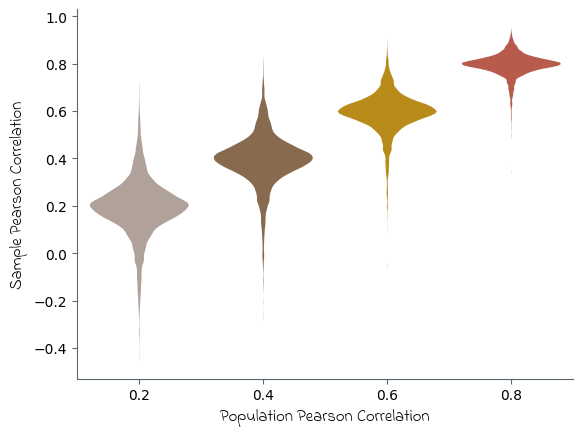

In [20]:
# Reload data
df = pd.read_csv("../reports/data/diff_spearman/monte-carlo.csv")

# Plot data
with sns.axes_style({"axes.edgecolor": anthracite}):
    ax = sns.violinplot(
        data=df,
        x="corr_sampled",
        y="pearson_corr",
        hue="corr_sampled",
        palette=full_palette,
        inner=None,
        linewidth=0,
        bw_adjust=2,
        legend=False
    )

# Add axis labels
ax.set_xlabel("Population Pearson Correlation", font=indie_flower, size=12)
ax.set_ylabel("Sample Pearson Correlation", font=indie_flower, size=12)

# Control figure aesthetics
sns.despine(ax=ax)
ax.tick_params(color=anthracite)

fig_population_sample = ax.get_figure()
plt.show()

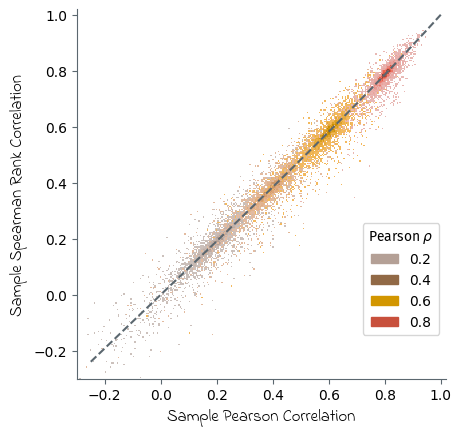

In [21]:
# Relation between Spearman and Pearson correlation - Eqn. 6.4 in "Ordinal measures of association" by Kruskal (1958)
pearson_values = np.linspace(-0.25, 1.0, 500)
spearman_values = (6 / np.pi) * np.arcsin(pearson_values / 2)

# Plot data
with sns.axes_style({"axes.edgecolor": anthracite}):
    ax = sns.histplot(
        data=df,
        x="pearson_corr",
        y="true_rank_corr",
        hue="corr_sampled",
        palette=full_palette,
        stat="density"
    )

# Add theoretical relation between Spearman and Pearson correlation
ax.plot(
    pearson_values,
    spearman_values,
    color=anthracite,
    linestyle="--"
)

# Add axis labels
ax.set_xlabel("Sample Pearson Correlation", font=indie_flower, size=12)
ax.set_ylabel("Sample Spearman Rank Correlation", font=indie_flower, size=12)

# Customize legend
legend = ax.get_legend()
legend.set(
    loc="lower right",
    bbox_to_anchor=(1, 0.1)
)
legend.set_title(
    r"Pearson $\rho$",
    prop=FontProperties(family="Fira Sans")
)

# Control figure aesthetics
ax.set_box_aspect(1)
ax.set_xlim(-0.3, 1.02)
ax.set_ylim(-0.3, 1.02)
sns.despine(ax=ax)
ax.tick_params(color=anthracite)

fig_sample_pearson_spearman = ax.get_figure()
plt.show()

### Collecting Results

We want to know what regularization strength we have to choose to achieve a desired proportion of non-zero partial derivatives.  
At the same time, we're interested in the error that this regularization strength brings about.

In [22]:
# Create copy and select largest error per combination (across all ``corr_sampled`` values)
partials_to_diff_sub = partials_to_diff.copy()
partials_to_diff_sub["avg_abs_diff"] = partials_to_diff_sub["avg_abs_diff"].round(3)
partials_to_diff_sub["non_zero_partials"] = partials_to_diff_sub["non_zero_partials"].round(3)
partials_to_diff_sub = partials_to_diff_sub.loc[partials_to_diff_sub.groupby(
    ["regularization", "size", "non_zero_partials", "regularization_strength"]
)["avg_abs_diff"].idxmax()]
partials_to_diff_sub = partials_to_diff_sub.drop(columns=["corr_sampled"])

# Filter select ``nono_zero_partials`` values
non_zero_partials_sub = [0.7, 0.8, 0.9, 0.95]
partials_to_diff_sub = partials_to_diff_sub[partials_to_diff_sub["non_zero_partials"].isin(non_zero_partials_sub)]

# Pivot DataFrame and show results
result = partials_to_diff_sub.pivot(index=["non_zero_partials", "size"], columns="regularization", values=["regularization_strength", "avg_abs_diff"])
result = result.sort_index(axis=1, level=[0, 1], ascending=False)
result

regularization_strength       avg_abs_diff       
regularization                              l2    kl           l2     kl
non_zero_partials size                                                  
0.70              28                     0.080  0.79        0.018  0.016
                  120                    0.020  0.74        0.004  0.003
                  496                    0.004  0.73        0.000  0.002
0.80              28                     0.090  1.08        0.022  0.026
                  120                    0.030  1.04        0.017  0.009
                  496                    0.005  1.02        0.001  0.005
0.90              28                     0.120  1.62        0.035  0.044
                  120                    0.030  1.58        0.017  0.019
                  496                    0.007  1.57        0.011  0.009
0.95              28                     0.150  2.15        0.046  0.057
                  120                    0.040  2.11        0.025  0.026
                  496                    0.008  2.10        0.015  0.013

## Benchmarking

Based on [PyTorch Benchmark](https://pytorch.org/tutorials/recipes/recipes/benchmark.html).

In [23]:
# Load and compare results
with open("../reports/data/diff_spearman/benchmarking_pre.pkl", "rb") as f:
    results = pickle.load(f)

compare = benchmark.Compare(results)
compare.trim_significant_figures()
compare.colorize()
compare.print()

[---------------------- Soft ranking ----------------------]
                                            |   l2   |   kl 
1 threads: -------------------------------------------------
      [b: 8, r: 1, l2: 0.004, kl: 0.730]    |    26  |    27
      [b: 8, r: 1, l2: 0.077, kl: 1.440]    |    26  |    30
      [b: 8, r: 1, l2: 0.150, kl: 2.150]    |    28  |    29
      [b: 8, r: 2, l2: 0.004, kl: 0.730]    |    39  |    41
      [b: 8, r: 2, l2: 0.077, kl: 1.440]    |    38  |    41
      [b: 8, r: 2, l2: 0.150, kl: 2.150]    |    39  |    41
      [b: 16, r: 1, l2: 0.004, kl: 0.730]   |    29  |    32
      [b: 16, r: 1, l2: 0.077, kl: 1.440]   |    30  |    33
      [b: 16, r: 1, l2: 0.150, kl: 2.150]   |    29  |    33
      [b: 16, r: 2, l2: 0.004, kl: 0.730]   |    42  |    48
      [b: 16, r: 2, l2: 0.077, kl: 1.440]   |    41  |    49
      [b: 16, r: 2, l2: 0.150, kl: 2.150]   |    41  |    49
      [b: 32, r: 1, l2: 0.004, kl: 0.730]   |    35  |    47
      [b: 32, r: 1, l2: 

There are two observations:

1. No significant difference between runs that only differ in the **regularization strength** being used.
2. No significant difference between runs that only differ in the **number of threads** being used.

To declutter the results, we repeat the benchmarking experiment for a single regularization strength and a single thread only.

In [24]:
# Load and compare results
with open("../reports/data/diff_spearman/benchmarking_final.pkl", "rb") as f:
    results = pickle.load(f)

compare = benchmark.Compare(results)
compare.trim_significant_figures()
compare.colorize()
compare.print()

[------------ Soft ranking ------------]
                      |    l2   |    kl 
1 threads: -----------------------------
      [b: 8, r: 1]    |     26  |     28
      [b: 8, r: 2]    |     38  |     41
      [b: 16, r: 1]   |     29  |     33
      [b: 16, r: 2]   |     41  |     49
      [b: 32, r: 1]   |     34  |     50
      [b: 32, r: 2]   |     51  |     82
      [b: 64, r: 1]   |     54  |    117
      [b: 64, r: 2]   |     94  |    218
      [b: 128, r: 1]  |    300  |    476
      [b: 128, r: 2]  |    650  |   1100
      [b: 256, r: 1]  |   1900  |   2660
      [b: 256, r: 2]  |   3480  |   5410
      [b: 512, r: 1]  |   8170  |  12400
      [b: 512, r: 2]  |  17300  |  25500

Times are in microseconds (us).



In [25]:
pattern = r"b:\s*(\d+),\s*r:\s*(\d+)"
extracted_results = []

for result in results:
    # Extract batch size and number of RDMs
    match = re.search(pattern, result.task_spec.sub_label)
    b = int(match.group(1))
    r = int(match.group(2))

    # Store data in list of dictionaries
    extracted_results.append({
        "rglr_type": result.task_spec.description,
        "b": b,
        "r": r,
        "median": result.median * 1e6
    })

# Create DataFrame
results_df = pd.DataFrame(extracted_results)
results_df

,rglr_type,b,r,median
0,l2,8,1,26.451958
1,kl,8,1,28.003333
2,l2,8,2,38.540625
3,kl,8,2,41.110375
4,l2,16,1,28.845708
5,kl,16,1,32.565458
6,l2,16,2,41.137833
7,kl,16,2,48.753708
8,l2,32,1,33.677292
9,kl,32,1,49.662063


In [26]:
# Extract results for one RDM, and compute execution time per sample
subset_df = results_df[results_df["r"] == 1].copy()
subset_df["per_sample"] = (subset_df["median"] / subset_df["b"]).round(1)
subset_df = subset_df.drop(columns=["r", "median"])
pivot_df = subset_df.pivot(index="b", columns="rglr_type", values="per_sample")
pivot_df

rglr_type,kl,l2
b,,
8,3.5,3.3
16,2.0,1.8
32,1.6,1.1
64,1.8,0.8
128,3.7,2.1
256,10.4,7.3
512,24.3,16.0
